# Time Series 

**Time series data** is an ordered sequence of values that collectively represents how a system, process or behavior changes over time.Time series is concerned with analysis of data collected over time such as **daily, weekly, monthly or yearly or time based values**.It is the _fastest growing database_ and there is an increased requirement to provide insights in real time.

**We can do the following with Time Series:**

**_Past:_**  
• Analyze historical trends  
• Look at the state of the system at any point in time

**_Present:_**  
• Real time monitoring  
• Troubleshoot problems as they occur

**_Future:_**    
• Identify and fix problems before they occur

_Time Series has methods for analysing data and forecasting the results._

**Time Series Analysis:** Analyzing the time series data to extract information through meaningful statistics and other characteristics of data.

**Time Series Forecast:** A model forecasting the future values based on the previously observed data

**Use Cases:** Time Series is widely used in non-stationary data like
1. Stock price
2. Weather
3. Retail sales
4. IoT / Sensors data

Let's discuss the time series with small sample of **airlines passengers** data back in time 

### Reading the Dataset

In [38]:
# import the required packages/libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

In [3]:
air_passengers = pd.read_csv('Air_Passengers.csv', header = 0, parse_dates = [0], names = ['Month','Passengers'], index_col = 0)

In [4]:
air_passengers.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [39]:
# check if any NaN values in the data
air_passengers.isnull().sum()

Passengers    0
dtype: int64

Befor continuing to _visualizing & forecasting_, let us discuss what are the **components of Time Series**

### **Time Series Components:**

**1. Level :** Level of time series is the **position of data** set taken from Y-axis.  
**2. Trend :** Long-term, **gradual increase or decrease** of data indicating direction of data over time.  
**3. Seasonality :** Seasonality is **Regular**, relatively **short-term repetitive up-and-down** fluctuations of the data.  
**4. Cyclical :** A **gradual, long-term, up-and-down potentially irregular** swings of the data. (Patterns repeating at irregular intervals of time)  
**5. Random Noise :** A **random increase or decrease** of the data for a specific time period. These fluctuations are neither systematic nor predictable.

In the above five components, every time series data have **Level & Noise** and **rest are optional**


### Visualize the data

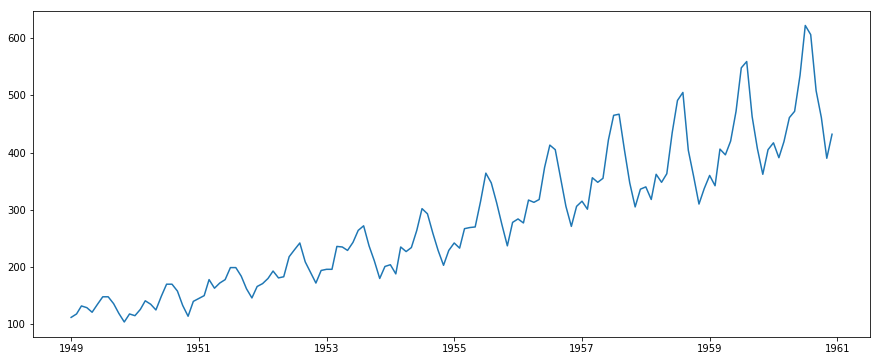

In [23]:
#Let us see the original data spread
plt.plot(air_passengers.Passengers)

#### Observations:
By observing the above plot, we can say that the trend of the data is **Linearly increasing**. Also there is lot of variance in the **Seasonality** as we can see the **patterns are getting larger** along with the time. Here no scope of Cyclical as the data is of small size. Let's see the components individually...

**To extract the vital patterns** of time series data we need to decompose the time series into its components. We do this through **Time Series Decomposition**.

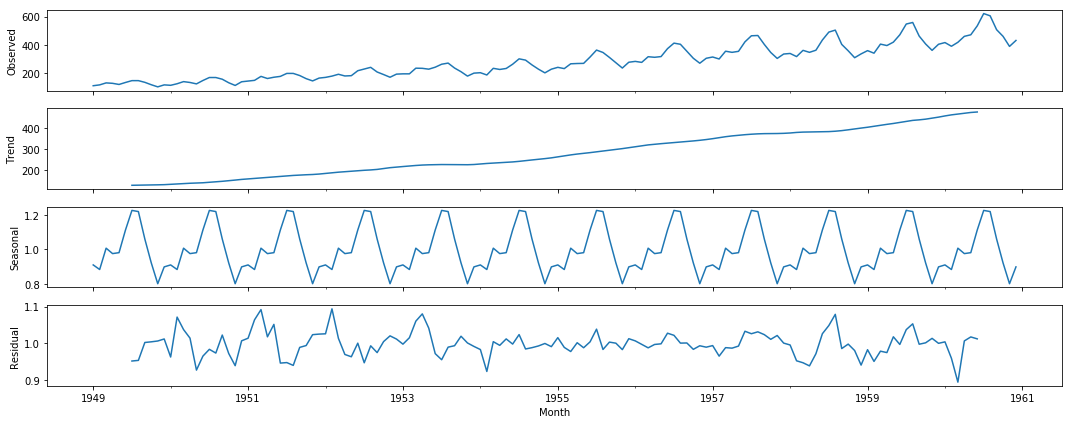

In [40]:
# Decomposing the time series
decomposition = seasonal_decompose(air_passengers.Passengers, model = 'multiplicative')
decomposition.plot()
plt.show()

So as we observed the **trend** is linearly increasing, patterns in data exists (**Seasonality** exists). The only thing which we don't have idea and don't have control is **Residual.** So lets drop it and check on Trend & Seasonality  

Here to make the non-stationary to stationary data we need to normalize the data. Firstly what is Stationary and Non-Stationary data.

**Stationary data** is where data has constant variance (no increase of pattern sizes) and constant mean.

**Non-stationary data** has increasing or decresing variance and mean.

To normalize the data, we use **log normilazation for variance in patterns and differencing for making trend constant**. _Without performing these and making data stationary we can't do Time Series Forecasting._

In [41]:
# Log normalization
log_air_passengers = np.log(air_passengers.Passengers)
log_air_passengers[1:10]

Month
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
1949-06-01    4.905275
1949-07-01    4.997212
1949-08-01    4.997212
1949-09-01    4.912655
1949-10-01    4.779123
Name: Passengers, dtype: float64

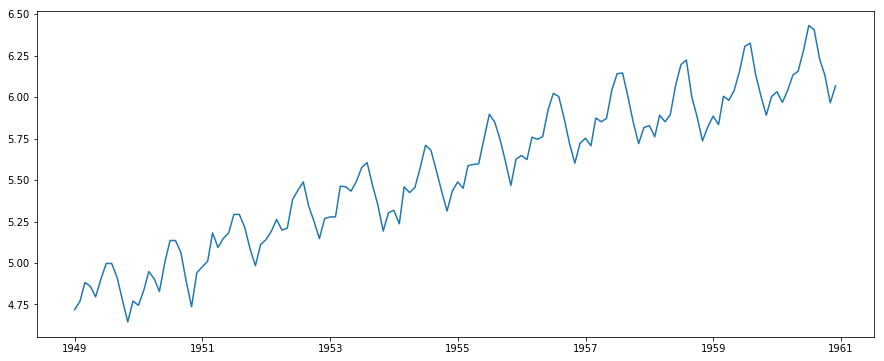

In [20]:
# Data after log normalization - constant variance
plt.plot(log_air_passengers)

If you see now, data has regular size patterns after log normalizing.

In [42]:
# differencing the data to normalize the trend
log_air_passengers_diff = log_air_passengers - log_air_passengers.shift()

In [44]:
# dropping the first value as it will be NaN if there is shift in index
log_air_passengers_diff.dropna(inplace=True)
log_air_passengers_diff[1:10]

Month
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
1949-07-01    0.091937
1949-08-01    0.000000
1949-09-01   -0.084557
1949-10-01   -0.133531
1949-11-01   -0.134733
Name: Passengers, dtype: float64

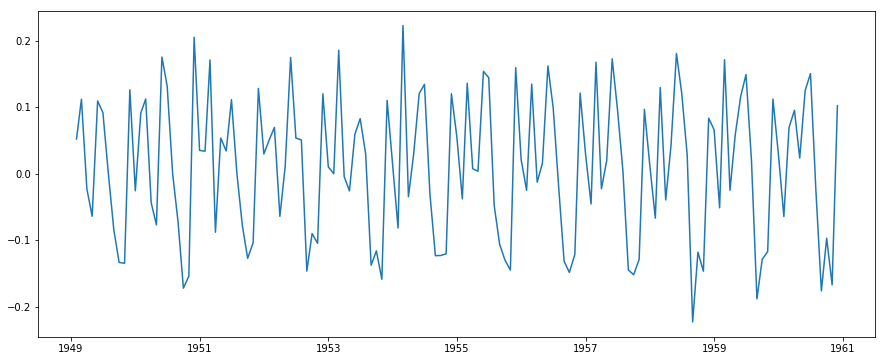

In [21]:
# Data after log normalizing & 1st order differencing - Constant variance & mean - Removal of trend
plt.plot(log_air_passengers_diff)

#### Now data is Stationary and having constant mean and variance

In [14]:
# Try what you could get when you do 2nd order differencing

#log_air_passengers_diff2 = log_air_passengers_diff - log_air_passengers_diff.shift()
#log_air_passengers_diff2.dropna(inplace=True)
#plt.plot(log_air_passengers_diff2)

# 1. Do the DF Test for stationarity
# 2. Check the q & p values from ACF and PACF respectively
# 3. Apply ARIMA(p,d,q)
# 4. Forecast and check if its better or worse

There are two ways to check the stationarity of a time series. The first is plot the moving variance and observe if it remains constant over time. However, you might not always be able to make such visual inferences. The second way is to use the **Dickey-Fuller test**, a statistical test with the null hypothesis that the **time series is non-stationary.**

_**If the test results in the test statistic significantly less than the critical values, we can reject the null hypothesis in favor of time series stationarity.**_

**Null Hypothesis (Ho):** The time series data is Non-Stationary  
**Alternate Hypothesis (Ha):** The time series data is Stationary

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
# Lets create a funtion to check whether the time series is stationary or not
def test_stationarity(timeseries):
    
    # Determining rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries,color='blue', label='original')
    mean = plt.plot(rolmean,color='red', label='Rolling Mean')
    std = plt.plot(rolstd,color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling  Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

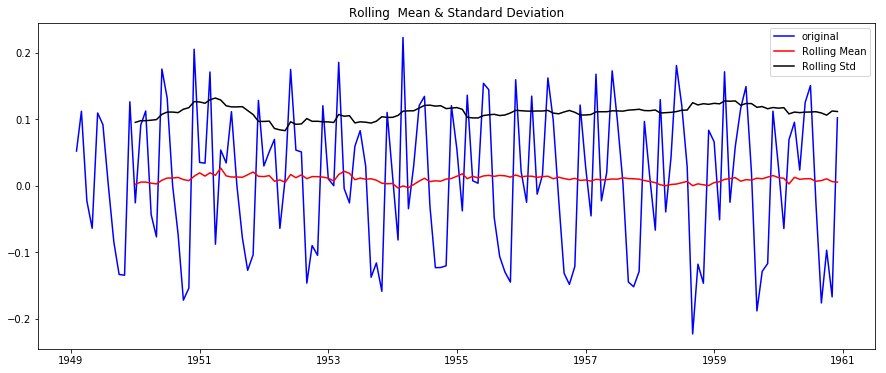

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [22]:
test_stationarity(log_air_passengers_diff)

Since the data is old, we are taking **90%  confidence interval (CI)**. By above values we can see that _test statistic(-2.717131) is beyond the 10% (100-90% CI) Critical value(-2.578960)_ and therefore having **low probality** for the data being Non-Stationary so we can conclude that time series data is Stationary

Now using ARIMA model which is one of the significant Time Series Forecasting technique we will work on our data

### **ARIMA:**
ARIMA (**Auto-Regressive Integrated Moving Average**) which is combination of two technique called Auto-Regression method and Moving Average method. These two methods are used to find the Auto-correlation.

**Auto-correlation** is correlation between a variable at t point & the same variable at previous time steps (t-k).  
_Here K is called lag. Lag is the periodic interval happend to towards past in the time series_  

Just like Linear Regression which helps in predicting the future values based on the correlation between the Feature and Response variables, We can predict the Time Series or forecast time series values with the Auto-Correlation.

ARIMA model take three input variables **(p,d,q)**.  
**'P'** is the number of lags to be considered for **AR** model  
**'q'** is number of terms(lags) included in **MA** model (Moving Average)  
**'d'** is the number of times of **differecing** the series data.  

**Python and R has packages for performing the ARIMA model**. _R has a package calle Auto-ARIMA which can extract p,q values help in giving best results_. **Python** has packages **acf,pacf** to get p and q values and then apply them to get the best results.

_ACF - Auto Correlation Function  
PACF - Partial Auto Correlation Function_

Since i'm good at python and all the code I have done till now is on Python I'm using Python here. (You can try in R)

In [52]:
# importing the packages and applying them with lags of 
from statsmodels.tsa.stattools import adfuller, acf, pacf
lag_acf = acf(log_air_passengers_diff.values, nlags = 20)
lag_pacf = pacf(log_air_passengers_diff.values, nlags = 20)
# here I have given lag value as 20 , but we can try with 12 as well.(because the data is monthly and year consists of 12 months)

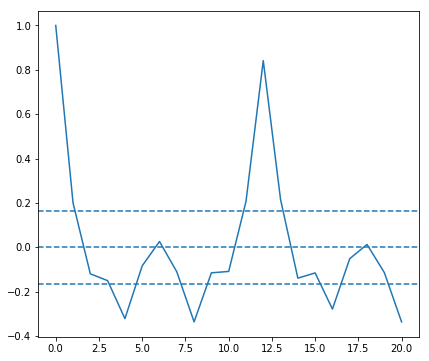

In [51]:
# ACF
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')

look at where the plot passes the upper confidence interval for the first time
 for ACF this around 2 and gives us the q value

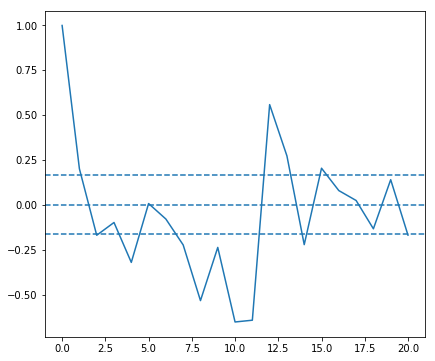

In [45]:
# PACF
plt.subplot(121) 
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')

look at where the plot passes the upper confidence interval for the first time
for PACF this is 2 and gives us the p value

we found the p and q values now lets import the ARIMA package and apply the model with these values

In [30]:
# importing the ARIMA model
from statsmodels.tsa.arima_model import ARIMA

When we run the model with (p,d,q) values with q=0 then it becomes _AR model_

C:\Users\manjunath\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\manjunath\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 1.5023')

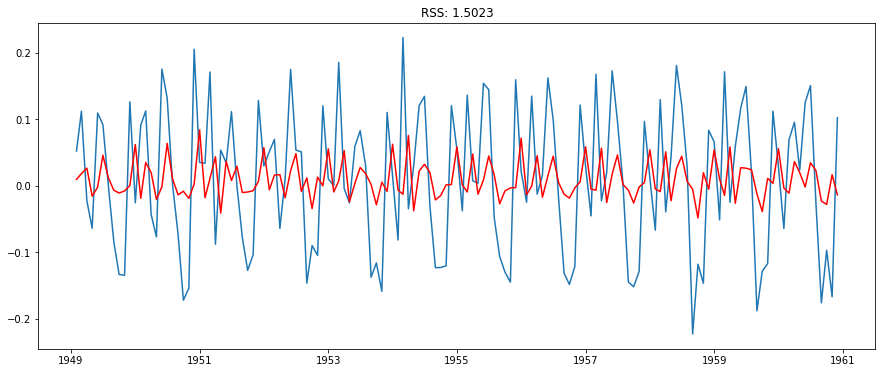

In [47]:
# AR model
model = ARIMA(log_air_passengers, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-log_air_passengers_diff)**2))
#ignor the non critical errors while code execution

When we run the model with (p,d,q) values with p=0 then it becomes _MA model_

C:\Users\manjunath\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\manjunath\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 1.4721')

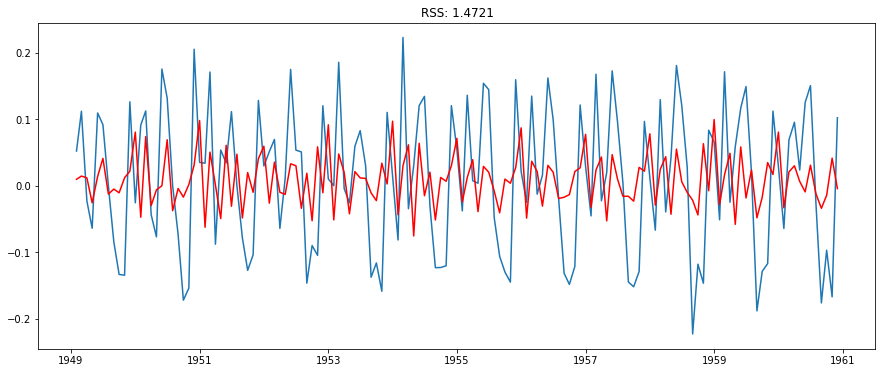

In [32]:
# MA model
model = ARIMA(log_air_passengers, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-log_air_passengers_diff)**2))

Both AR and MA models alone not capturing the variance or patterns in the series. So lets apply ARIMA model with the **p & q** values obtained from ACF and PACF

C:\Users\manjunath\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\manjunath\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 1.0292')

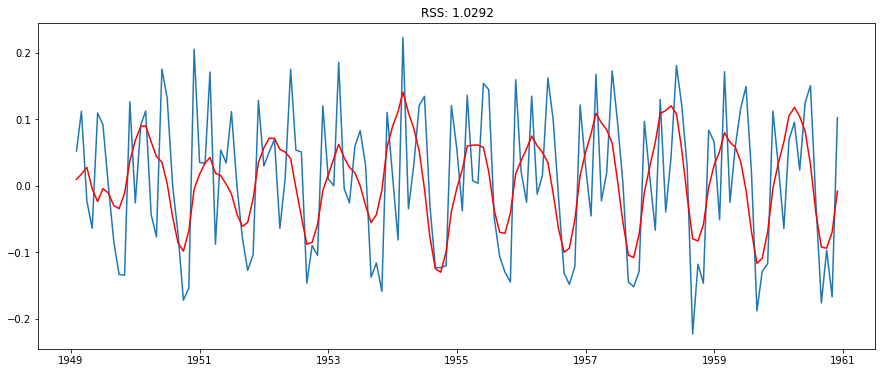

In [33]:
# ARIMA model
model = ARIMA(log_air_passengers, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-log_air_passengers_diff)**2))

Looks like now we can clearly see the variance or patterns are captured best by our model. Though it looks like there is value which defines performance the model. It is called **RSS - Residual Sum of Square**

I calculated it and make it printed on the top of plot. Out of three models **AR, MA, ARIMA** , **_ARIMA_** got best score.
The least the RSS score the better the model  

_Now Predict the time series with this ARIMA model_

In [34]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [35]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [36]:
predictions_ARIMA_log = pd.Series(log_air_passengers.ix[0], index=log_air_passengers.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

C:\Users\manjunath\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Text(0.5,1,'Air line passengers time series prediction')

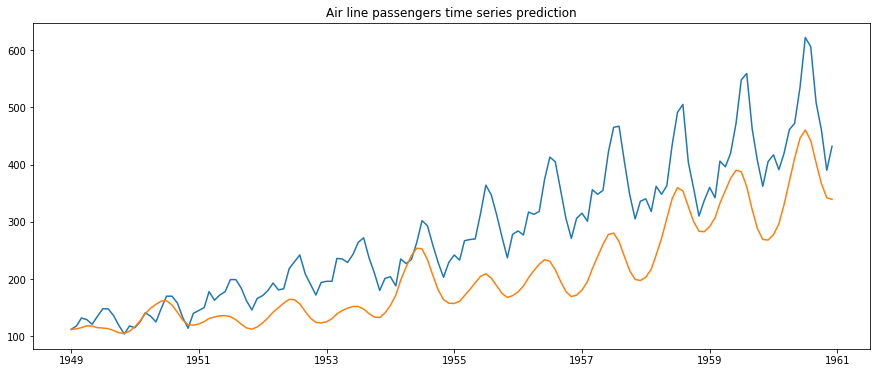

In [53]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(air_passengers)
plt.plot(predictions_ARIMA)
plt.title("Air line passengers time series prediction")

Apart from **ARIMA** there are lot techniques to forecast the Time Series like **SARIMA, SARIMAX, VAR, VARMA, VARIMAX, SES, HWES.** 

It is more fun to learn about these different types of data and thier significance.  
_Happy Learning_ :)